gpp - gpp  :  ('a', 'a')
gpp - ra  :  ('a', 'a')
gpp - npp  :  ('a', 'b')
gpp - rh  :  ('a', 'b')
gpp - ch4  :  ('a', 'b')
ra - gpp  :  ('a', 'a')
ra - ra  :  ('a', 'a')
ra - npp  :  ('a', 'b')
ra - rh  :  ('a', 'b')
ra - ch4  :  ('a', 'b')
npp - gpp  :  ('a', 'b')
npp - ra  :  ('a', 'b')
npp - npp  :  ('a', 'a')
npp - rh  :  ('a', 'b')
npp - ch4  :  ('a', 'b')
rh - gpp  :  ('a', 'b')
rh - ra  :  ('a', 'b')
rh - npp  :  ('a', 'b')
rh - rh  :  ('a', 'a')
rh - ch4  :  ('a', 'a')
ch4 - gpp  :  ('a', 'b')
ch4 - ra  :  ('a', 'b')
ch4 - npp  :  ('a', 'b')
ch4 - rh  :  ('a', 'a')
ch4 - ch4  :  ('a', 'a')
ch4
rh
npp
ra
gpp


Text(0, 0.5, 'Warming effect on NCE\n(g C m$^{-2}$ yr$^{-1}$)')

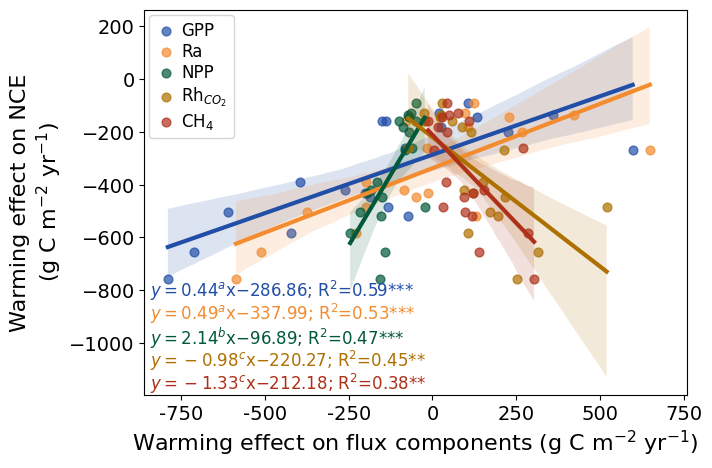

In [2]:
# NCE changed with warming under aCO2 and eCO2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress


import statsmodels.api as sm
import statsmodels.formula.api as smf

# def cal_reg_diff(x1, y1, x2, y2): # justify if there is significant difference between two groups data
#     # create two group datasets
#     x = np.concatenate([x1, x2])
#     y = np.concatenate([y1, y2])
#     group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

#     # create a model include interactive object
#     data = {'y': y, 'x': x, 'group': group}
#     model = smf.ols('y ~ x + group + x * C(group)', data=data).fit()

#     pvalue_diff_slope     = model.pvalues['x:C(group)[T.2]']
#     pvalue_diff_intercept = model.pvalues['C(group)[T.2]']

#     if pvalue_diff_slope < 0.05:
#         res_ab_slope = ("a", "b")
#     else:
#         res_ab_slope = ("a", "a")

#     if pvalue_diff_intercept < 0.05:
#         res_ab_intercept = ("a", "b")
#     else:
#         res_ab_intercept = ("a", "a")

#     return res_ab_slope, res_ab_intercept

def cal_reg_diff(x_ambient, y_ambient, x_elevated, y_elevated):
    """
    Fits y ~ x + group + x:C(group) and returns the p‑values for
    differences in slope and intercept between the two groups.  If only
    one group is present the p‑values will be None.
    """
    # Create a DataFrame with a categorical group column
    x = np.concatenate([x_ambient, x_elevated])
    y = np.concatenate([y_ambient, y_elevated])
    group_labels = (['ambient'] * len(x_ambient)) + (['elevated'] * len(x_elevated))
    df = pd.DataFrame({'y': y, 'x': x, 'group': group_labels})
    df['group'] = df['group'].astype('category')

    # Fit the model
    model = smf.ols('y ~ x + group + x:C(group)', data=df).fit()

    # Dynamically extract p‑values for group effects
    slope_pval = None
    intercept_pval = None
    for term, pval in model.pvalues.items():
        if term.startswith('x:C(group)'):
            slope_pval = pval
        elif term.startswith('C(group)'):
            intercept_pval = pval

    # slope_pval and intercept_pval will be None if there is only one group
    if slope_pval is not None and slope_pval < 0.05:
        res_ab_slope = ('a', 'b')
    else:
        res_ab_slope = ('a', 'a')

    if intercept_pval is not None and intercept_pval < 0.05:
        res_ab_intercept = ('a', 'b')
    else:
        res_ab_intercept = ('a', 'a')

    return res_ab_slope, res_ab_intercept

df_data = pd.read_excel("1_data_minus_2013.xlsx") 
df_data["nce"] = (df_data["gpp_Tree"] + df_data["gpp_Shrub"] + df_data["gpp_Sphagnum"] - 
                 (df_data["ra_Tree"] + df_data["ra_Shrub"] + df_data["ra_Sphagnum"]) - 
                  df_data["rh"] - df_data["ch4"])
df_data["gpp"] = df_data["gpp_Tree"]+ df_data["gpp_Shrub"] + df_data["gpp_Sphagnum"]
df_data["npp"] = df_data["npp_Tree"] + df_data["npp_Shrub"] + df_data["npp_Sphagnum"]
df_data["ra"]  = df_data["ra_Tree"] + df_data["ra_Shrub"] + df_data["ra_Sphagnum"]
df_data = df_data[df_data["year"]>2016]
df_data = df_data[["year", "plot", "warming", "co2", "gpp", "ra", "npp", "rh", "ch4", "nce"]].reset_index(drop=True)

# df_data[["ra", "rh", "ch4"]] = -df_data[["ra", "rh", "ch4"]]

df_data_aco2 = df_data[df_data["co2"] == 0].copy()
df_data_eco2 = df_data[df_data["co2"] == 500].copy()

ls_warming = [0, 2.25, 4.5, 6.75, 9]

ls_dfs = []
for idx_warming, iwarming in enumerate(ls_warming[1:]):
    for df_data_co2 in [df_data_aco2, df_data_eco2]:
        df_control = df_data_co2[df_data_co2["warming"]==0].copy()
        df_warm    = df_data_co2[df_data_co2["warming"]==iwarming].copy()
        df_merge   = pd.merge(df_warm, df_control, on="year", how="outer")
        for icol in ["gpp", "ra", "npp", "rh", "ch4", "nce"]:
            df_merge[icol] = df_merge[icol+"_x"] - df_merge[icol+"_y"]
        df_save = df_merge[["year", "plot_x", "warming_x", "co2_x", "gpp", "ra", "npp", "rh", "ch4", "nce"]].rename(columns={"plot_x":"plot", "warming_x":"warming", "co2_x": "co2"})
        # print(df_save)
        ls_dfs.append(df_save)

df_diff = pd.concat(ls_dfs, ignore_index=True)

fig, ax = plt.subplots(figsize=(7, 5))
# ls_colors = ["#2F81B5", "#E51818"]
# ls_pos = [(0.05, 0.95),( 0.8, 0.2)]

ls_colors = ["#214EA7", "#F38B2F", "#025939"]
ls_colors_rh = ["#947959", "#6b6b6b"]

# dict_colors = {
#     "gpp": "#214EA7", "ra": "#F38B2F", "npp": "#025939", "rh": "#947959", "ch4":"#6b6b6b"
# }

dict_colors = {"gpp": "#214EA7", "ra": "#F38B2F", "npp": "#025939", "rh": "#AE7000", "ch4": "#AE3019"}

dict_labels = {
    "gpp": "GPP", "ra": "Ra", "npp": "NPP", "rh": "Rh$_{CO_2}$", "ch4":"CH$_4$"
}

df_slope = pd.DataFrame(columns=["var", "r2", "slope", "abs_slope", "labels", "color", "rp_vals"])

# mark
dict_marks = {
    "npp": "b", "ch4": "c", "rh": "c", "ra": "a", "gpp": "a"
}

for idx_var, ivar in enumerate(["gpp", "ra", "npp", "rh", "ch4"]):
    df_plt = df_diff[df_diff["co2"]==0].copy()
    x = df_plt[ivar].values
    y = df_plt["nce"].values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    linestyle = "-" if p_value < 0.05 else "--"
    if p_value < 0.001:
        mark_p = "***"
    elif p_value<0.01:
        mark_p = "**"
    elif p_value <0.05:
        mark_p = "*"
    else:
        mark_p = " "
    sns.regplot(x=x, y=y, color=dict_colors[ivar], 
                scatter_kws={"s": 40, "alpha": 0.7},label=dict_labels[ivar],
                line_kws={"linestyle": linestyle, "linewidth": 3}, ax=ax)
    # df_slope.loc[len(df_slope)] = [ivar, r_value*r_value, slope, abs(slope), dict_labels[ivar], dict_colors[ivar], 
    #                                rf"Slope = {slope:.2f}; " + f"R$^2$={r_value*r_value:.2f}"+ (rf"$^{{{mark_p}}}$" if mark_p else "")]
    intercept_str = f"+ {intercept:.2f}" if intercept >= 0 else f"- {abs(intercept):.2f}"
    # df_slope.loc[len(df_slope)] = [ivar, r_value*r_value, slope, abs(slope), dict_labels[ivar], dict_colors[ivar], 
                                #    rf"y = {slope:.2f}$^{dict_marks[ivar]}$x {intercept_str}; " + f"R$^2$={r_value*r_value:.2f}"+ (rf"$^{{{mark_p}}}$" if mark_p else "")]
    # slope_str = f"\u00A0\u00A0\u00A0\u00A0{slope:.2f}" if slope >= 0 else f"- {abs(slope):.2f}"
    df_slope.loc[len(df_slope)] = [ivar, r_value*r_value, slope, abs(slope), dict_labels[ivar], dict_colors[ivar], 
                                   rf"$y = {slope:.2f}$$^{dict_marks[ivar]}$x$ {intercept_str}$; " + f"R$^2$={r_value*r_value:.2f}"+ mark_p]
    # ax.text(0.01,0.06*(idx_var+1), 
    #         rf"R$^2$ = {r_value**2:.2f}" + (rf"$^{{{mark_p}}}$" if mark_p else ""), 
    #         va="top", ha="left", fontsize=12, transform=ax.transAxes, color=dict_colors[ivar])

for ivar in ["gpp", "ra", "npp", "rh", "ch4"]:
    for jvar in ["gpp", "ra", "npp", "rh", "ch4"]:
        res_ab_slope, res_ab_intercept = cal_reg_diff(df_plt[ivar].values, df_plt["nce"].values, df_plt[jvar].values, df_plt["nce"].values)
        print(ivar, "-", jvar, " : ", res_ab_slope)

df_sorted = df_slope.sort_values(by="r2", key=abs, ascending=True).reset_index(drop=True)


for idx_var in range(5):
    print(df_sorted.loc[idx_var, "var"])
    ax.text(0.01,0.06*(idx_var+1)+0.001, 
                # rf"R$^2$ = {r_value**2:.2f}" + (rf"$^{{{mark_p}}}$" if mark_p else ""),
                df_sorted.loc[idx_var, "rp_vals"],
                va="top", ha="left", fontsize=12, transform=ax.transAxes, color=dict_colors[df_sorted.loc[idx_var, "var"]])

ax.set_xlim(-859,759)
# ax.set_xticks([-750, -500, -250, 0, 250, 500, 750, 1000])
# ax.set_xticklabels([-750, -500, -250, 0, 250, 500, 750, 1000])

handles, labels = ax.get_legend_handles_labels() # 0"gpp", 1"ra", 2"npp", 3"rh", 4"ch4"

order = [2, 4, 3, 1, 0]  # "npp", "ch4", "rh", "ra", "gpp"
order = [0, 1, 2, 3, 4]  

# 4. 重新绘制 legend
ax.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc="upper right",
    ncol=1,
    fontsize=12,
    bbox_to_anchor=(0.997, 0.7),
    labelspacing=0.2,
    columnspacing=0.7,
    handlelength=1.2,
    handletextpad=0.3,
    borderaxespad=0.3
)

ax.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc="upper left",
    ncol=1,
    fontsize=12,
    # bbox_to_anchor=(0.997, 0.7),
    labelspacing=0.2,
    columnspacing=0.7,
    handlelength=1.2,
    handletextpad=0.3,
    borderaxespad=0.3
)

# ax.legend(loc="upper right", ncol=1, fontsize=12,
#                      bbox_to_anchor=(0.997, 0.7),
#                     labelspacing=0.2, 
#                     columnspacing=0.7,
#                     handlelength=1.2,
#                     handletextpad=0.3,
#                     borderaxespad=0.3 
#         )
ax.set_xticks([-750, -500, -250, 0, 250, 500, 750])
ax.set_xticklabels([-750, -500, -250, 0, 250, 500, 750])

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# ax.set_xlabel(r'$\Delta$Flux Components (g C m$^{-2}$ yr$^{-1}$)', fontsize=16)
# ax.set_ylabel(r'$\Delta$NCE (g C m$^{-2}$ yr$^{-1}$)', fontsize=16)

ax.set_xlabel('Warming effect on '+'flux components (g C m$^{-2}$ yr$^{-1}$)', fontsize=16)
ax.set_ylabel('Warming effect on '+'NCE\n(g C m$^{-2}$ yr$^{-1}$)', fontsize=16)